In [17]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd

In [18]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [19]:
df1 = read_csv('merge_oil.csv', header=0, index_col=0)
df1.index = pd.to_datetime(df1["Date"],format="%Y-%m-%d")
df1 = df1[["ONGC_Close","ONGC_Open","ONGC_High","ONGC_Low","ONGC_Volume","Price"]]
#"Price","US_Price","Dollar_eq","Open","High","Low","Volume","Percent_Change"

df1 = df1.iloc[::-1]
print(df1.head())
values = df1.values

values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())


            ONGC_Close   ONGC_Open   ONGC_High    ONGC_Low  ONGC_Volume  \
Date                                                                      
2011-12-12  171.600006  174.800003  177.233002  170.332993    3607640.0   
2011-12-13  170.266998  170.867004  172.199997  168.367004    3822892.0   
2011-12-14  168.033005  169.667007  171.332993  167.332993    3553436.0   
2011-12-15  167.399994  166.667007  169.167007  165.332993    7229764.0   
2011-12-16  166.867004  167.399994  172.966995  164.100006    3192585.0   

             Price  
Date                
2011-12-12  5203.0  
2011-12-13  5342.0  
2011-12-14  5209.0  
2011-12-15  5036.0  
2011-12-16  4903.0  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.240378   0.247373   0.258856   0.260323   0.067810   0.593148  0.233085   
2   0.233085   0.226006   0.231695   0.248991   0.073374   0.617694  0.220862   
3   0.220862   0.219487   0.227016   0.243032   0.066408   0.594208  0.217398   
4  

In [20]:
values = reframed.values
#print(values)
split = int(len(list(df1["Price"]))*0.8)
train = values[:split,:]
test = values[split:,:]
train_X,train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#print(test_y)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1326, 1, 6) (1326,) (331, 1, 6) (331,)


Train on 1326 samples, validate on 331 samples
Epoch 1/50
 - 1s - loss: 0.2836 - val_loss: 0.1161
Epoch 2/50
 - 0s - loss: 0.1416 - val_loss: 0.0373
Epoch 3/50
 - 0s - loss: 0.0727 - val_loss: 0.0644
Epoch 4/50
 - 0s - loss: 0.0709 - val_loss: 0.0475
Epoch 5/50
 - 0s - loss: 0.0625 - val_loss: 0.0398
Epoch 6/50
 - 0s - loss: 0.0537 - val_loss: 0.0374
Epoch 7/50
 - 0s - loss: 0.0465 - val_loss: 0.0308
Epoch 8/50
 - 0s - loss: 0.0386 - val_loss: 0.0250
Epoch 9/50
 - 0s - loss: 0.0311 - val_loss: 0.0199
Epoch 10/50
 - 0s - loss: 0.0252 - val_loss: 0.0151
Epoch 11/50
 - 0s - loss: 0.0222 - val_loss: 0.0125
Epoch 12/50
 - 0s - loss: 0.0203 - val_loss: 0.0122
Epoch 13/50
 - 0s - loss: 0.0194 - val_loss: 0.0120
Epoch 14/50
 - 0s - loss: 0.0190 - val_loss: 0.0120
Epoch 15/50
 - 0s - loss: 0.0189 - val_loss: 0.0120
Epoch 16/50
 - 0s - loss: 0.0187 - val_loss: 0.0120
Epoch 17/50
 - 0s - loss: 0.0185 - val_loss: 0.0119
Epoch 18/50
 - 0s - loss: 0.0183 - val_loss: 0.0118
Epoch 19/50
 - 0s - loss: 

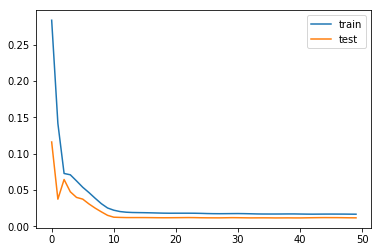

Test RMSE: 2.804


In [21]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


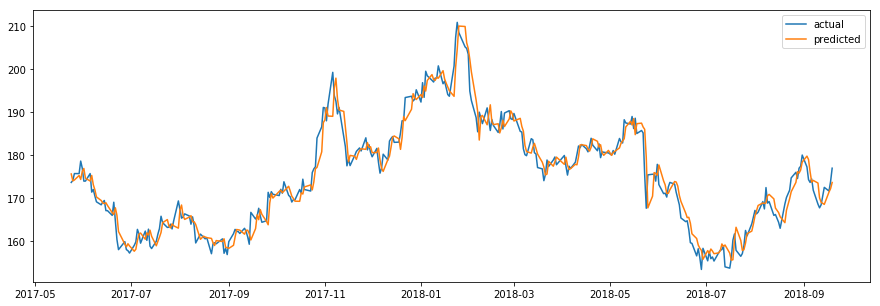

In [22]:
df = read_csv('merge_oil.csv', header=0, index_col=0)
df = df.iloc[::-1]
df.index = pd.to_datetime(df["Date"],format="%Y-%m-%d")

plot_df = pd.DataFrame({'Date':df.iloc[split+1:]["Date"],'Actual':inv_y,'Predicted':inv_yhat})
plot_df.index = pd.to_datetime(plot_df["Date"],format="%Y-%m-%d")

split = int(len(list(df["IOC_Low"]))*0.8)
dates = df.iloc[split+1:]["Date"]

fig = pyplot.figure(figsize=(15,5))

pyplot.plot(plot_df['Actual'],label='actual')
pyplot.plot(plot_df['Predicted'],label='predicted')
#pyplot.xticks(rotation=90)
pyplot.legend()
pyplot.show()

#print(dates)

In [23]:
print(list(inv_y))

[173.7, 174.15, 175.75, 175.75, 178.65, 177.0, 174.0, 174.0, 175.75, 171.45, 172.05, 170.55, 169.2, 168.5, 169.1, 169.5, 167.15, 167.15, 166.05, 169.1, 164.8, 160.45, 158.1, 159.95, 158.1, 157.85, 157.3, 159.1, 159.9, 162.8, 161.7, 159.6, 162.4, 160.25, 162.85, 158.9, 158.35, 160.05, 161.7, 163.0, 165.85, 164.35, 163.25, 163.3, 164.0, 162.9, 164.75, 169.4, 167.4, 165.4, 165.7, 166.4, 165.9, 164.0, 165.7, 163.7, 159.65, 161.7, 160.95, 160.6, 160.9, 157.15, 159.45, 159.7, 159.45, 160.6, 157.25, 158.4, 156.95, 159.95, 161.8, 162.8, 162.3, 162.3, 161.85, 163.05, 162.3, 161.05, 159.35, 166.75, 165.2, 165.9, 167.7, 165.9, 164.45, 164.8, 171.4, 170.2, 171.55, 170.95, 170.65, 172.1, 171.2, 173.85, 170.7, 170.35, 169.15, 169.7, 169.65, 172.05, 171.2, 174.45, 172.05, 171.7, 176.0, 176.85, 177.35, 184.0, 186.6, 191.10002, 190.99998, 188.0, 191.85, 199.25002, 193.8, 192.55002, 189.59999, 191.10002, 184.19998, 182.0, 177.55, 179.15, 177.6, 180.0, 180.9, 181.3, 181.7, 181.0, 184.05, 181.25, 182.45, 

In [24]:
print(list(inv_yhat))

[175.66196, 174.05887, 174.26067, 175.30281, 174.38773, 176.24283, 176.93358, 174.68944, 174.02094, 175.31506, 173.16328, 171.98138, 170.3278, 169.50482, 168.92783, 168.76207, 168.98561, 168.34933, 166.6775, 166.24034, 167.80582, 166.05911, 162.30031, 159.38808, 158.75073, 159.465, 158.95636, 157.72963, 158.19052, 160.18533, 161.71632, 161.94534, 160.51355, 161.98314, 161.45491, 162.61026, 161.20448, 158.99524, 160.0396, 160.992, 162.0864, 164.3545, 165.07564, 163.59756, 163.12378, 164.09236, 163.63515, 163.08458, 167.28273, 168.45207, 165.99094, 165.12111, 165.65965, 165.98083, 164.5956, 164.5799, 163.94476, 160.49539, 161.2252, 161.03082, 160.8844, 160.7065, 159.68149, 159.05597, 160.20154, 159.97504, 160.60928, 158.6013, 158.57468, 158.38766, 159.1042, 161.01701, 162.77505, 162.70189, 162.62852, 161.68628, 162.59045, 162.60469, 161.79907, 160.3428, 162.97061, 166.15424, 165.05225, 167.37938, 166.292, 164.61955, 163.86981, 168.89516, 171.0887, 170.06822, 171.5942, 171.88873, 171.3162

In [25]:
#OHLC only

            ONGC_Close   ONGC_Open   ONGC_High    ONGC_Low  ONGC_Volume
Date                                                                   
2011-12-12  171.600006  174.800003  177.233002  170.332993    3607640.0
2011-12-13  170.266998  170.867004  172.199997  168.367004    3822892.0
2011-12-14  168.033005  169.667007  171.332993  167.332993    3553436.0
2011-12-15  167.399994  166.667007  169.167007  165.332993    7229764.0
2011-12-16  166.867004  167.399994  172.966995  164.100006    3192585.0
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1   0.240378   0.247373   0.258856   0.260323   0.067810  0.233085  0.226006   
2   0.233085   0.226006   0.231695   0.248991   0.073374  0.220862  0.219487   
3   0.220862   0.219487   0.227016   0.243032   0.066408  0.217398  0.203188   
4   0.217398   0.203188   0.215327   0.231504   0.161440  0.214482  0.207170   
5   0.214482   0.207170   0.235834   0.224398   0.057081  0.202806  0.204275   

    var3(t)   v

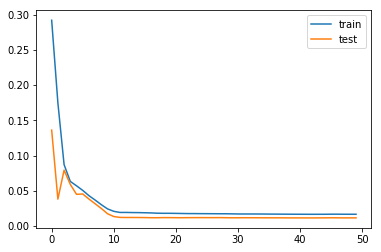

Test RMSE: 2.835


In [28]:
df1 = read_csv('merge_oil.csv', header=0, index_col=0)
df1.index = pd.to_datetime(df1["Date"],format="%Y-%m-%d")
df1 = df1[["ONGC_Close","ONGC_Open","ONGC_High","ONGC_Low","ONGC_Volume"]]
#"Price","US_Price","Dollar_eq","Open","High","Low","Volume","Percent_Change"

df1 = df1.iloc[::-1]
print(df1.head())
values = df1.values

values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())


values = reframed.values
#print(values)
split = int(len(list(df1["ONGC_Close"]))*0.8)
train = values[:split,:]
test = values[split:,:]
train_X,train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#print(test_y)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)



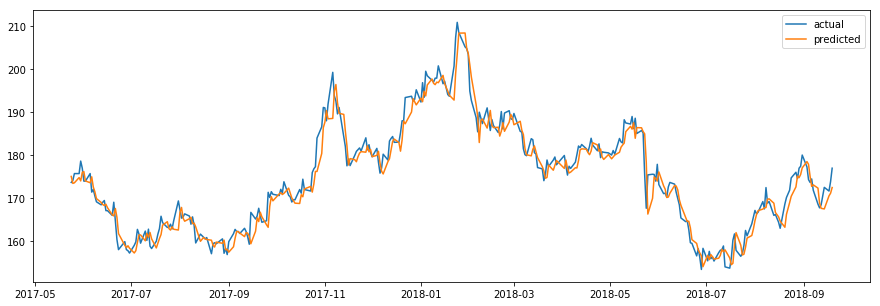

In [29]:
df = read_csv('merge_oil.csv', header=0, index_col=0)
df = df.iloc[::-1]
df.index = pd.to_datetime(df["Date"],format="%Y-%m-%d")

plot_df = pd.DataFrame({'Date':df.iloc[split+1:]["Date"],'Actual':inv_y,'Predicted':inv_yhat})
plot_df.index = pd.to_datetime(plot_df["Date"],format="%Y-%m-%d")

split = int(len(list(df["IOC_Low"]))*0.8)
dates = df.iloc[split+1:]["Date"]

fig = pyplot.figure(figsize=(15,5))

pyplot.plot(plot_df['Actual'],label='actual')
pyplot.plot(plot_df['Predicted'],label='predicted')
#pyplot.xticks(rotation=90)
pyplot.legend()
pyplot.show()

#print(dates)

In [30]:
print(list(inv_y))

[173.7, 174.15, 175.75, 175.75, 178.65, 177.0, 174.0, 174.0, 175.75, 171.45, 172.05, 170.55, 169.2, 168.5, 169.1, 169.5, 167.15, 167.15, 166.05, 169.1, 164.8, 160.45, 158.1, 159.95, 158.1, 157.85, 157.3, 159.1, 159.9, 162.8, 161.7, 159.6, 162.4, 160.25, 162.85, 158.9, 158.35, 160.05, 161.7, 163.0, 165.85, 164.35, 163.25, 163.3, 164.0, 162.9, 164.75, 169.4, 167.4, 165.4, 165.7, 166.4, 165.9, 164.0, 165.7, 163.7, 159.65, 161.7, 160.95, 160.6, 160.9, 157.15, 159.45, 159.7, 159.45, 160.6, 157.25, 158.4, 156.95, 159.95, 161.8, 162.8, 162.3, 162.3, 161.85, 163.05, 162.3, 161.05, 159.35, 166.75, 165.2, 165.9, 167.7, 165.9, 164.45, 164.8, 171.4, 170.2, 171.55, 170.95, 170.65, 172.1, 171.2, 173.85, 170.7, 170.35, 169.15, 169.7, 169.65, 172.05, 171.2, 174.45, 172.05, 171.7, 176.0, 176.85, 177.35, 184.0, 186.6, 191.10002, 190.99998, 188.0, 191.85, 199.25002, 193.8, 192.55002, 189.59999, 191.10002, 184.19998, 182.0, 177.55, 179.15, 177.6, 180.0, 180.9, 181.3, 181.7, 181.0, 184.05, 181.25, 182.45, 

In [31]:
print(list(inv_yhat))

[175.0869, 173.47043, 173.60667, 174.82068, 174.05019, 176.02156, 176.21187, 174.0467, 173.62543, 174.99513, 172.6187, 171.51721, 169.94339, 169.05522, 168.55365, 168.33861, 168.63806, 167.84323, 166.17323, 165.9253, 167.65038, 165.60802, 161.82466, 159.09647, 158.56288, 158.9959, 158.43408, 157.3213, 157.85298, 159.7874, 161.49413, 161.51485, 160.14886, 161.89162, 160.94537, 162.08112, 160.6184, 158.48944, 159.60078, 160.68608, 161.60419, 163.79178, 164.58238, 162.98297, 162.63467, 163.41615, 162.83336, 162.64969, 166.73102, 167.88937, 165.40846, 164.69237, 165.27031, 165.61482, 164.12279, 164.24335, 163.38614, 160.03224, 160.92905, 160.58133, 160.45363, 160.28325, 159.10547, 158.69775, 159.85126, 159.56981, 160.3015, 158.0475, 158.16962, 157.5143, 158.76268, 160.734, 162.3087, 162.29225, 161.94681, 161.12068, 162.0463, 161.9063, 161.1998, 159.45818, 162.38193, 165.49649, 164.60797, 166.77255, 165.7311, 163.84482, 163.28156, 168.13365, 170.38669, 169.41786, 171.03224, 171.30185, 170.8